In [2]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import scipy.sparse as scps
import scipy.sparse.linalg as ssl
import math

In [3]:
def maillage(n):
#
# Une discretisation possible d'une EDP elliptique sur le domaine ]0,1[ x ]0,1[
# Le carre [0,1]x[0,1] est maille uniquement avec des triangles; 
# Les conditions limites sont de type Dirichlet uniquement   => neumann  =[];
#
# Entrees :
# n : nombre de points par cote du care => Npts points de discretisation au
# total
#
# Sorties :
# coordinates : matrice a deux colonnes. Chaque ligne contient les 
# coordonnes 2D d'un des points de la discretisation. Ces sommets seront 
# identifies a l'indice de la ligne correspondante dans la matrice
# coordinates.
# elements3 : matrice a trois colonnes. Chaque ligne contient les indices 
# des sommets d'un element triangle, dans le sens antihoraire. 
# dirichlet : vecteur colonne des indices des sommets de la frontiere de
# Dirichlet.
# neumann : matrice a deux colonnes. Chaque ligne contient les indices 
# des deux sommets d'une arete de la frontiere de Neumann.
# (neumann est vide sur cet exemple)
#
##################################################################################
    h=1/(n-1)
    npoin       = n*n ; 
    nelem       = 2*(n-1)*(n-1) ;
    coordinates = np.zeros((npoin,2)); 
    elements3   = (np.zeros((nelem,3))).astype(int) ;
    neumann     = [];
    dirichlet=(np.zeros((4*n-4,1))).astype(int)
    # Coordonnees et connectivites :
    e = -1 ; 
    p = -1 ;
    x=np.zeros((n+1,1))
    x[n,0]=1.
    for l in range (n+1):
        x[l,0]=l*h
    for j in range (n):
            for i in range(n):
                p = p + 1  
                coordinates[p,0] = x[i,0]  
                coordinates[p,1] = x[j,0] 
                if ((i != n-1) & (j != n-1)):
                    p1 = p
                    p2 = p1 + 1 
                    p3 = p1 + n 
                    p4 = p2 + n 
                    e = e + 1 
                    elements3[e,0] = p1 
                    elements3[e,1] = p2 
                    elements3[e,2] = p3 
                    e = e + 1
                    elements3[e,0] = p4 
                    elements3[e,1] = p3 
                    elements3[e,2] = p2 
    #Liste des sommets de la frontiere de Dirichlet:
    p=-1
    for j in range(n):
        p=p+1
        dirichlet[p,0] = j  
    for j in range(n*2-1,n*(n-1),n):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-1,n*n-n-1,-1):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-2*n,n-1,-n):
        p=p+1
        dirichlet[p,0] = j 

    return coordinates, elements3,dirichlet, neumann


In [4]:
def show(coordinates,u):
#
# Fonction d'affichage de la solution u sur le maillage defini par
# elements3, coordinates.
#
# Entrees:
# elements3 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# u : vecteur colonne de longueur egale au nombre de lignes de
# coordinates contenant les valeurs de la solution a afficher aux
# points de la discretisation.
#
# Sorties : Aucune, mais la fonction doit s'afficher dans une figure.
##########################################################################
    ax= plt.figure().add_subplot(projection='3d')
    ax.plot_trisurf(coordinates[:,0],coordinates[:,1],u,linewidth=0.2,antialiased=True)
    plt.show()

**Partie I : maillage triangulaire et conditions de Dirichlet**

In [5]:
#Question 1
def matrice_de_raideur(coord,T):
    #les coordonnées des sommets du triangle T
    x = coord[T][:,0]
    y = coord[T][:,1]

    alpha = (x[1]-x[0])*(y[2]-y[0]) - (x[2]-x[0])*(y[1]-y[0])
    M =  np.zeros((3,3))

    for i in range(3):
        for j in range(3): 
            gradI = (1/alpha) * np.array([y[(i+1)%3]-y[(i+2)%3],x[(i+2)%3]-x[(i+1)%3]])
            gradJ = (1/alpha) * np.array([y[(j+1)%3]-y[(j+2)%3],x[(j+2)%3]-x[(j+1)%3]])
            M[i,j] = (alpha/2) * np.dot(np.transpose(gradI),gradJ)
    return M,alpha

#Question 2
def matrice_A(coord,elements3):
    n = len(coord)
    A = np.zeros((n,n))
    for k in range(len(elements3)) :
        T = elements3[k]
        M,_ = matrice_de_raideur(coord, T)
        for i in range(3):
            for j in range(3):
                A[T[i],T[j]] += M[i,j] 
    return A


#Question 3
def f(x,y):
        return 1
def ud(x,y):
    return 1
def g(x,y):
    return 1

def Assemblage_b(triangles, coord,  A, dirichlet):
    b = np.zeros((len(coord),1))

    for k in range(len(triangles)):
        x = coord[triangles[k]][:,0]
        y = coord[triangles[k]][:,1]

        xG = (x[0] + x[1] + x[2])/3
        yG = (y[0] + y[1] + y[2])/3
        _, alpha = matrice_de_raideur(coord,triangles[k])

        for i in range(3):
            b[triangles[k,i]] += (alpha/6)*f(xG, yG)
    
    uh = np.zeros((len(coord),1))
    for l in dirichlet:
        uh[l] = ud(coord[l,0], coord[l,1])
    # Appliquer les conditions aux limites de Dirichlet
    b = b - A.dot(uh)
    return b,uh 

def Resolution(A, b, uh, dirichlet,coord): 
    #Reduire la matrice A et b
    sommets_horsdirichlet = np.array([i for i in range(len(coord)) if i not in dirichlet])
    A_aux = A[sommets_horsdirichlet]
    A = A_aux[:,sommets_horsdirichlet]
    
    b = b[sommets_horsdirichlet]
    #Resolution
    x = (np.linalg.inv(A)).dot(b)
    uh[sommets_horsdirichlet] = x
    return uh

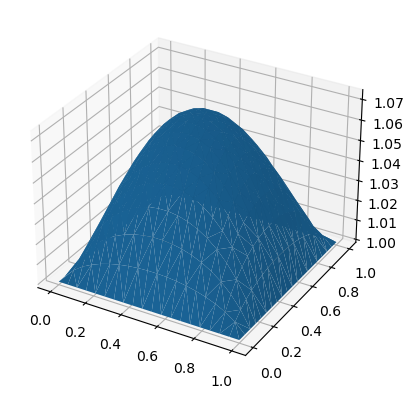

In [6]:
coordinates, elements3, dirichlet, neumann = maillage(20)
A = matrice_A(coordinates,elements3)
b,uh = Assemblage_b(elements3, coordinates,  A, dirichlet) 
sol = Resolution(A, b, uh, dirichlet,coordinates)


show(coordinates, sol.flatten())


**Partie II : maillage mixte et ajoût des conditions de Neumann**

**Calcul de la matrice de raideur :**

En procédant de même que dans le cas du maillage triangulaire et en appliquant la formule de changement de variable dans la fin du sujet, on obtient la formule suivante :

$$M_{ij} =  \displaystyle \int_U  {\nabla \phi_i(u,v)^T (J_\phi^T J_\phi)^{-1} \nabla \phi_j(u,v) |J_\phi|}\, \mathrm{dv} \, \mathrm{du}\$$

D'où : 

$$M_{ij} =  \displaystyle \int_0^1 \int_0^1 {\nabla \phi_i(u,v)^T (J_\phi^T J_\phi)^{-1} \nabla \phi_j(u,v) |J_\phi|}\, \mathrm{du} \, \mathrm{dv}\$$

et on a : 

\begin{aligned}
\phi_1(\xi, \zeta) &= (1 - \xi)(1 - \zeta), \\
\phi_2(\xi, \zeta) &= \xi(1 - \zeta), \\
\phi_3(\xi, \zeta) &= \xi\zeta, \\
\phi_4(\xi, \zeta) &= (1 - \xi)\zeta
\end{aligned}

Donc : 
\begin{aligned}
\nabla \phi_1 &= \left( \frac{\partial \phi_1}{\partial \xi}, \frac{\partial \phi_1}{\partial \zeta} \right)^T = \left( -1 + \zeta, -1 + \xi \right)^T \\
\nabla \phi_2 &= \left( \frac{\partial \phi_2}{\partial \xi}, \frac{\partial \phi_2}{\partial \zeta} \right)^T = \left( 1 - \zeta, -\xi \right)^T \\
\nabla \phi_3 &= \left( \frac{\partial \phi_3}{\partial \xi}, \frac{\partial \phi_3}{\partial \zeta} \right)^T = \left( \zeta, \xi \right)^T \\
\nabla \phi_4 &= \left( \frac{\partial \phi_4}{\partial \xi}, \frac{\partial \phi_4}{\partial \zeta} \right)^T = \left( -\zeta, 1 - \xi \right)^T
\end{aligned}

Et comme $(J_\phi^T J_\phi)^{-1}$ est carré et symétrique alors :
$(J_\phi^T J_\phi)^{-1} =
\begin{pmatrix}
a & b \\
b & c \\
\end{pmatrix}$ 

Calculons par exemple $M_{11}$ :
$$
M_{11} = \int_0^1 \int_0^1 \left( \nabla \phi_1(u,v)^T \begin{pmatrix} a & b \\ b & c \end{pmatrix} \nabla \phi_1(u,v) \right) |J_\phi| \, \mathrm{du} \, \mathrm{dv} 
       = \int_0^1 \int_0^1 \left( a(-1+v)^2 + 2b(-1+u)(-1+v)+c(-1+u)^2 \right) |J_\phi| \, \mathrm{du} \, \mathrm{dv}
$$
Et donc finalement on trouve :
$$M_{11} = (a/3+b/2+c/3) |J_\phi| = \frac{|J_\phi|}{6}(2a+3b+2c)$$


En procédant de même, on trouve :
$$
M = \frac{|J_\phi|}{6} \begin{bmatrix}
    2a + 3b + 2c & -2a + c & -a - 3b - c & a - 2c \\
    -2a + c & 2a - 3b + 2c & a - 2c & -a + 3b - c \\
    -a - 3b - c & a - 2c & 2a + 3b + 2c & -2a + c \\
    a - 2c & -a + 3b - c & -2a + c & 2a - 3b + 2c
\end{bmatrix}
$$








**Calcul du terme de Neumann**

Pour le calcul du terme de Neumann, on a utilisé la formule des trapèzes pour approximer cette intégrale :

$$
\int_{x_1}^{x_2} f(x) \, dx \approx \frac{d}{2} \left( f(x_1) + f(x_2) \right) \\

\text{où } d \text{ est la distance entre $x_1$ et $x_2$ et } f(x) \text{ est la fonction à intégrer.}
$$






In [7]:
############################# Maillage mixte ################
e3=np.array([[1,2,12],[2,3,12],[3,4,14],[4,5,14],[2,15,3],[3,15,4]]).astype(int)
e4=np.array([[0,1,12,11],[11,12,13,10],[12,3,14,13],[10,13,8,9],[13,14,7,8],[14,5,6,7]]).astype(int)
dds=np.array([2,15,4,6,7,8,9,10,11,0]).astype(int)
nns=np.array([[4,5],[5,6],[0,1],[1,2]]).astype(int)
ccs=np.array([[0.,0.],[0.33333333333333,0],[0.53333333333333,0.],
                      [0.66666666666667,0.33333333333333],[1.,0.47],[1,0.66666666666667],
                     [1.,1.],[0.66666666666667,1.],[0.33333333333333,1.], [0.,1.],
                     [0.,0.66666666666667],[0.,0.33333333333333],[0.33333333333333,0.33333333333333],
                     [0.33333333333333,0.66666666666667],[0.66666666666667,0.66666666666667],[1.,0.]])

In [8]:
def matrice_raideur_quadrangle(coord,Q):
    #les coordonnées des sommets du quadrangle Q
    x = coord[Q][:,0]
    y = coord[Q][:,1]
    
    #le jacobien
    J_Q = np.array([[x[1]-x[0],x[3]-x[0]], [y[1]-y[0],y[3]-y[0]]])
    produitJQ_inv = np.linalg.inv(np.dot(np.transpose(J_Q),J_Q))
    a,b,c = produitJQ_inv[0,0], produitJQ_inv[1,0], produitJQ_inv[1,1]
   
    M = np.array([
        [2*a+3*b+2*c,-2*a+c,-a-3*b-c, a-2*c],
        [-2*a+c, 2*a-3*b+2*c, a-2*c, -a+3*b-c],
        [-a-3*b-c, a-2*c, 2*a + 3*b+2*c, -2*a+c],
        [a-2*c, -a+3*b-c,-2*a+c, 2*a-3*b+2*c]
    ])
    # le déterminant du jacobien
    det_JQ = np.linalg.det(J_Q)
    alpha = det_JQ
    return det_JQ/6 * M , alpha


def matrice_A_mixte(coord,elements3,elements4):
    n = len(coord)
    A = np.zeros((n,n))

    ##Triangulaire
    for k in range(len(elements3)) :
        T = elements3[k]
        M,_ = matrice_de_raideur(coord, T)
        for i in range(3):
            for j in range(3):
                A[T[i],T[j]] += M[i,j] 

    #Quadrangle
    for k in range(len(elements4)) :
        Q = elements4[k]
        M,_ = matrice_raideur_quadrangle(coord, Q)
        for i in range(4):
            for j in range(4):
                A[Q[i],Q[j]] += M[i,j] 
    return A


def Assemblage_b_mixte(triangles,elements4, coord,  A, dirichlet,neumann):
    b = np.zeros((len(coord),1))

    ##Triangulaire
    for k in range(len(triangles)):
        x = coord[triangles[k]][:,0]
        y = coord[triangles[k]][:,1]

        xG = (x[0] + x[1] + x[2])/3
        yG = (y[0] + y[1] + y[2])/3
        _, alpha = matrice_de_raideur(coord,triangles[k])

        for i in range(3):
            b[triangles[k,i]] += (alpha/6)*f(xG, yG)

    ##Quadrangle
    for k in range(len(elements4)):
        x = coord[elements4[k]][:,0]
        y = coord[elements4[k]][:,1]

        xG = (x[0] + x[1] + x[2] + x[3])/4
        yG = (y[0] + y[1] + y[2] + y[3])/4
        _, alpha = matrice_raideur_quadrangle(coord,elements4[k])

        for i in range(4):
            b[elements4[k,i]] += (alpha/4)*f(xG, yG)
    
    
    uh = np.zeros((len(coord),1))
    for l in dirichlet:
        uh[l] = ud(coord[l,0], coord[l,1])
    # Appliquer les conditions aux limites de Dirichlet
    b = b - A.dot(uh)
    
    ##Terme de Neumann 
    for ij in neumann:
        i,j = ij
        pt_i,pt_j = coord[i],coord[j]
        distance = math.sqrt((pt_j[0]-pt_i[0])**2 +(pt_j[1]-pt_i[1])**2)
        b[i] += distance/2 * (g(pt_i[0],pt_i[1])+g(pt_j[0],pt_j[1]))
        b[j] += distance/2 * (g(pt_i[0],pt_i[1])+g(pt_j[0],pt_j[1]))

    return b,uh 

def Resolution_mixte(coord,A, b, uh, dirichlet): 
    #Reduire la matrice A et b
    sommets_horsdirichlet = np.array([i for i in range(len(coord)) if i not in dirichlet])
    A_aux = A[sommets_horsdirichlet]
    A = A_aux[:,sommets_horsdirichlet]
    
    b = b[sommets_horsdirichlet]
    #Resolution
    x = (np.linalg.inv(A)).dot(b)
    uh[sommets_horsdirichlet] = x
    return uh

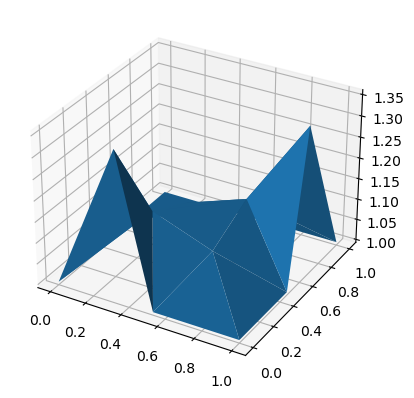

In [9]:
A = matrice_A_mixte(ccs,e3,e4)
b,uh = Assemblage_b_mixte(e3,e4, ccs,  A, dds,nns)
sol = Resolution_mixte(ccs,A, b, uh, dds)

show(ccs, sol.flatten())


**Compléments  :  un nouveau terme dans l'EDP**

Nous nous intéressons au problème suivant avec les notations précédentes :
$$
\left\{
    \begin{array}{ll}
        \begin{aligned}
            -\Delta u(x,y) + c_0 u(x,y) = f(x,y) & \,  sur ~ \Omega, \\
            u(x,y) = 0 & \, sur  ~ \partial \Omega,
        \end{aligned}
    \end{array}
\right.
$$

avec $c_0 > 0$ une constante.

Nous allons résoudre ce problème en le discrétisant par la méthode des éléments finis de Lagrange avec des éléments finis de type $P_1$, comme ce qui a été réalisé en Partie I.

### **Question 1 :**
1-1 Montrons que la formulation variationnelle de se problème peut s’ecrire :
Trouver $u \in H^1_0(\Omega)$ telle que
$$
\int_\Omega {\nabla u . \nabla w} \, \mathrm{d}x + c_0 \int_\Omega {u w} \, \mathrm{d}x = \int_\Omega {f w} \, \mathrm{d}x
$$ 
avec $w \in H^1_0(\Omega)$.

On cherche à trouver $u \in H^2(\Omega)$ avec $\forall v \in L^2(\Omega)$ telle que : 

$$\int_\Omega {-\Delta u v + c_0 u v} \, \mathrm{d}x =  \int_\Omega {f v} \, \mathrm{d}x$$

Or $\Omega$ est un domaine ouvert borné à frontiere lipshitzienne, donc d'après la formule de Green, on a: 

\begin{aligned}
    \int_\Omega \nabla u \nabla v dx - \int_{\partial\Omega} \gamma_1(u) \gamma_0(v) dx + c_0 \int_\Omega u v dx &= \int_\Omega f v dx
\end{aligned}

Or, d'après la condition de Dirichlet ( $\forall(x,y) \in \partial\Omega$  $u(x,y) = 0$ donc $u \in H^1_0(\Omega)$.) Alors, $\gamma_0(v) = 0$ sur $\partial\Omega$ (i.e que $v \in H^1_0(\Omega)$) 

On deduit que : 

\begin{array}{|c|}
\hline
\begin{aligned}
\int_\Omega \nabla u \nabla v \, dx + c_0 \int_\Omega u v \, dx &= \int_\Omega f v \, dx
\end{aligned} \\
\hline
\end{array}


Avec $u,v \in H^1_0(\Omega)$



Le problème peut s'écrire sous la forme: $a(u,v) = l(v)$ avec 
$$
a : \left\{
    \begin{aligned}
        H^1_0(\Omega) \times H^1_0(\Omega) & \longrightarrow \mathbb{R}\\
        (u,v) & \longrightarrow \displaystyle \int_\Omega {\nabla u . \nabla v} \, dx + c_0 \int_\Omega {u v} \, dx \, = \, <u,v>_{1,\Omega} + c_0 <u,v>_{L^2(\Omega)}
    \end{aligned}
\right.
$$

et 

$$
l : \left\{
    \begin{aligned}
        H^1_0(\Omega) & \longrightarrow \mathbb{R}\\
        v & \longrightarrow \displaystyle \int_\Omega {fv} \, dx \, = \, <f,v>_{L^2(\Omega)}
    \end{aligned}
\right.
$$

**Etude de a sur $H^1_0(\Omega) \times H^1_0(\Omega)$ :**

<u>bilinéarité : </u>

On a **a** une forme bilinéaire par rapport à u et v, donc bilinéaire.

<u>Continuité : </u>
D'après Cauchy-Schwartz : 

$$
\begin{aligned}
    & \mid a(u,v)\mid = \mid <u,v>_{1,\Omega} + c_0 <u,v>_{L^2(\Omega)} \mid \\
    & \mid a(u,v)\mid \leq \mid <u,v>_{1,\Omega} \mid + c_0 \mid <u,v>_{L^2(\Omega)} \mid \\
    & \mid a(u,v)\mid \leq \mid u \mid_{1,\Omega}\mid v \mid_{1,\Omega} + c_0 \| u \|_{L^2(\Omega)} \| v \|_{L^2(\Omega)}\\
\end{aligned}
$$ 


D'après l'inégalité de Poincarré, $\exists C > 0$ tel que $\|v\|_{L^2(\Omega)} \leq C \|v\|_{0,1}$, donc $|a(u,v)| \leq (1+c_0C)\|u\|_{0,1} \|v\|_{0,1}$.


D'ou la continuité de la forme **a**.

<u>Coercivité : </u>
on a $|a(v,v)| =  |v|^2_{0,1} + c_0||v||^2_{L^2(\Omega)}\ >= |v|^2_{0,1}$

D'où la $\textbf{coercivité}$ de la forme a.


**Etude de l sur $H^1_0(\Omega)$ :**

<u>linéarité : </u>

On a **l** une forme linéaire par rapport à u, d'apres la linéarité de l'intégrale.

<u>Continuité : </u>
on a 
$$
\mid l(v) \mid = \mid <f,v>_{L^2(\Omega)} \mid
$$

D'après Cauchy-Schwartz :
$$ 
\mid l(v)\mid \leq \|f\|_{L^2(\Omega)}\|v\|_{L^2(\Omega)}
$$ 
 
D'après l'inégalité de Poincarré, $\exists C > 0$ tel que $\|v\|_{L^2(\Omega)} \leq C \|v\|_{0,1}$, donc :

$$
\mid l(w) \mid \leq \|f\|_{L^2(\Omega)} C |v|_{0,1} 
$$

Donc $l$ est  $\textbf{continue}$ sur $H_0^1(\Omega)$.

D'après le théorème de Lax-Milgram, $\exists !$ $u \in H^1_0(\Omega)$ tq : 
$$ 
\forall v \in H^1_0(\Omega), \, a(u,v) = l(v)
$$

On déduit que le problème admet une unique solution.



### **Question 2 :**

2 - Montrons que la forme variationnelle discrète aboutit au système linéaire d'équations Ax = b :

Comme $(\mu_k)$ sont les fonctions de base des éléments finis de $n$ degrés de liberté, on peut directement définir les coefficients $u_i$ comme les coefficients de $u$ par rapport à ces fonctions de base, c'est-à-dire :

$$ 
u = \sum_{i=1}^n u_i \mu_i \quad \text{et} \quad v = \sum_{i=1}^n v_i \mu_i
$$

D'après la forme variationnelle discrète du problème, on cherche $u$ tel que $\forall v, \, a(u, v) \, = \, l(v)$, c'est-à-dire :

$$ 
a\left(\sum_{i=1}^n u_i \mu_i, \sum_{i=1}^n v_i \mu_i\right) \, = \, l\left(\sum_{i=1}^n v_i \mu_i\right)
$$

Grâce à la bilinéarité de $a$ et la linéarité de $l$, on obtient :

$$
\sum_{i,j} u_i v_j a(\mu_i, \mu_j) = \sum_{i=1}^n v_i l(\mu_i)
$$

Alors : 

$$
\sum_{i=1}^n v_i \left(l(\eta_i) - \sum_{j=1}^n u_j a(\eta_i, \eta_j)\right) = 0
$$


En particulier, $\forall i \in [1,n]$ on prend $v = \eta_i$, où $\eta_i$ est la fonction de base correspondant à un certain $i$, alors tous les $v_j$ pour $j \neq i$ sont nuls. Ainsi, on a 
$$
\forall i \in [1,n], \, l(\eta_i) - \sum_{j=1}^n u_j a(\eta_j,\eta_i) = 0
$$ 
Alors : 

$$
\sum_{j=1}^n u_j a(\eta_j,\eta_i) = l(\eta_i)
$$

On obtient le système $Ax = b$ avec $A \in \mathbb{R}^{n \times n}$, $x,b \in \mathbb{R}^n$ tels que 
$$
\forall i, j \in [1, n], \quad A_{ij} = a(\eta_j,\eta_i) = \int_\Omega {\nabla \eta_i^T \nabla \eta_j} \, dx + c_0 \int_\Omega {\eta_i \eta_j} \, dx,
$$

$$ 
\forall i \in [1, n], \quad b_i = l(\eta_i) = \int_\Omega {f \eta_i} \, \mathrm{d}x
$$ 




### **Question 3 :**

3- Appliquer la strategie de l’element de reference pour le calcul de $\int_T {\nabla \eta_i \cdot \nabla \eta_j} \, dx$ afin d’assembler la matrice A du système.

On s'intérese aux foncions de base associées au 3 segments d'wn triangle

Def: Coordonnees barycentriques nelatives à un triangle. Soit $T$ un triangle de sommets $\left(A^{(1)}, A^{(2)}, A^{(3)}\right)$ tq: $\sum_{i=1}^3 \lambda_i(M) A^{(i)}$, de plus, on a les prop suivantes:

(i) $\forall(i, j) \in[1,3]^2: \lambda_i\left(A^{(j)}\right)=\operatorname{Sij}$

(ii)$ \quad M \in\left(A^{(i)} A^{(j)}\right) \Leftrightarrow \lambda_p(M)=0 \quad($ avec $i \neq j \neq p)$

(iii) $M \in T \Leftrightarrow \forall i \in[1,3]: 0 \leqslant \lambda_i(m) \leqslant 1$

Sur chaque triangle ${T_k}$ , les fonctions de base s’annulent ou sont égales à une coordonnée barycentrique. Nous devons donc calculer l’intégrale du produit de deux coordonnées barycentriques (pour c constante) et l’intégrale du produit scalaire de leur gradient.

<img src="./image.jpeg" alt="Alt text">



- Introduisons donc un triangle de référence
$$
\hat{T}=\left\{\left(\hat{x}_1, \hat{x}_2\right) \in \mathbb{R}^2 ; \hat{x}_1 \geq 0, \hat{x}_2 \geq 0, \hat{x}_1+\hat{x}_2 \leq 1\right\} .
$$
- Soient $\hat{A}^1=(0,0), \hat{A}^2=(1,0)$ et $\hat{A}^3=(0,1)$ ses trois sommets et $\hat{\lambda}_i$ les coordonnées barycentriques correspondantes.
- Soit $T_k$ un triangle générique du maillage, de sommets $A_k^1, A_k^2, A_k^3$.
- Il existe une et une seule application affine $F_k$ telle que $F_k\left(\hat{A}^j\right)=A_k^j, j=1,2,3$.
- En effet, comme les applications affines conservent les barycentres, nous avons simplement
$$
F_k(\hat{M})=\hat{\lambda}_1(\hat{M}) A_k^1+\hat{\lambda}_2(\hat{M}) A_k^2+\hat{\lambda}_3(\hat{M}) A_k^3
$$
ou encore $\lambda_i\left(F_k(\hat{M})\right)=\hat{\lambda}_i(\hat{M})$, où les premières coordonnées barycentriques sont prises par rapport aux sommets de $T_k$ dans l'ordre croissant des exposants.

Avec un changement de variable, l'expression des coordonnées barycentriques dans le triangle de référence en fonction des coordonnées cartésiennes est particulièrement simple :
$$
\hat{\lambda}_1=1-\hat{x}_1-\hat{x}_2: \hat{\lambda}_2=\hat{x}_1 ; \hat{\lambda}_3=\hat{x}_2 .
$$

 Prenons un exemple de calcul pour l'intégrale $\int_{T_k} \lambda_2^2 d x$.
Nous utilisons le changement de variables $x=F_k(\hat{x})$. Puisque ce changement de variable est affine, son jacobien est constant, nous pouvons alors calculer
$$
\begin{aligned}
\int_{T_k} \lambda_1^2(x) d x & =\int_{\hat{T}} \hat \lambda_2^2(\hat{x}) J d \hat{x}=2 J \int_{\hat{T}} \hat{x}_1^2 d \hat{x} \\
& =J \int_0^1 \hat{x}_1^2\left(\int_0^{1-\hat{x}_2} d \hat{x}_2\right) d \hat{x}_1= J \int_0^1 \hat{x}_1^2\left(1-\hat{x}_1\right) d \hat{x}_1 \\
& = J\left(\frac{1}{3}-\frac{1}{4}\right)=\frac{J}{12}
\end{aligned}
$$

En échangeant les sommets, nous trouvons $\int_{T_k} \lambda_1^2(x) d x=\int_{T_k} \lambda_3^2(x) d x=\frac{J}{12}$. Un calcul similaire montre que $\int_{T_k} \lambda_i(x) \lambda_j(x) d x=\frac{J}{24}$, pour tous $i \neq j$. 

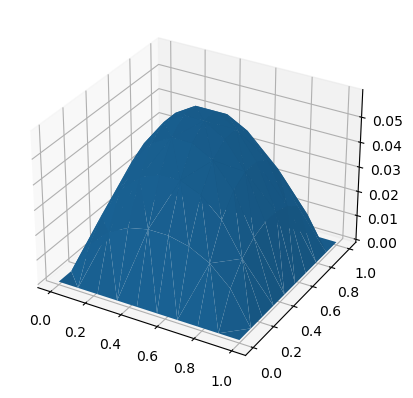

In [10]:
def matrice_A_compl(coord,elements3,c0):
    n = len(coord)
    A = np.zeros((n,n))
    for k in range(len(elements3)) :
        T = elements3[k]
        M,alpha  = matrice_de_raideur(coord, T)
        detJ = alpha
        for i in range(3):
            for j in range(3):
                if (j==k) :
                   A[T[i],T[j]] += M[i,j] + c0*detJ/12
                else :
                   A[T[i],T[j]] += M[i,j] + c0*detJ/24
    return A


def Assemblage_b_compl(triangles, coord):
    b = np.zeros((len(coord),1))

    for k in range(len(triangles)):
        x = coord[triangles[k]][:,0]
        y = coord[triangles[k]][:,1]

        xG = (x[0] + x[1] + x[2])/3
        yG = (y[0] + y[1] + y[2])/3
        _, alpha = matrice_de_raideur(coord,triangles[k])

        for i in range(3):
            b[triangles[k,i]] += (alpha/6)*f(xG, yG)

    return b

def Resolution_compl(A, b, coord, dirichlet): 
    uh = np.zeros((len(coord),1))
    #Reduire la matrice A et b
    sommets_horsdirichlet = np.array([i for i in range(len(coord)) if i not in dirichlet])
    A_aux = A[sommets_horsdirichlet]
    A = A_aux[:,sommets_horsdirichlet]
    
    b = b[sommets_horsdirichlet]
    #Resolution
    x = (np.linalg.inv(A)).dot(b)
    uh[sommets_horsdirichlet] = x
    return uh


def f(x,y):
    return 1


coordinates, elements3, dirichlet, neumann = maillage(10)
A = matrice_A_compl(coordinates,elements3,c0=5)

b = Assemblage_b_compl(elements3, coordinates) 
sol = Resolution_compl(A, b, coordinates, dirichlet)


show(coordinates, sol.flatten())